<h1 style='text-align: center;'> 
Physics-Informed Neural Networks (PINNs)
</h1>

`Narváez J.`
<p style='text-align: justify;'>

<p style='text-align: justify;'>  
In this notebook, we will introduce the concept of Physics-Informed Neural Networks (PINNs). We will create simple examples of how it works for solving ODES. </p>

# Solving ODES with PINNs

<p style='text-align: justify;'>  
The process of solving a differential equation with a neural network using the ODE itself to define the cost function is known as <b> physics-informed neural network</b>.
</p>

Let's consider the next general ODE:

<div id="ODE"></div>

$$
\begin{equation} \label{ODE} \tag{1}
 f(x, u(x), u^\prime(x), u^{\prime\prime}(x), \cdots, u^{(n)}(x))=0 \hspace{0.5cm}\text{for } x\in D,
\end{equation}
$$

<p style='text-align: justify;'> 
subject to some Boundary Conditions in $\partial D$. Here, $u(x)$ is the function to be evaluated in its domain $D$. Now, we chose a trial solution $\Psi(x)$ such that, by construction, it satisfied the boundary condition, as follows,
</p>

<div id="Trial"></div>

$$
\begin{equation} \label{Trial} \tag{2}
 \Psi(x, w) = A(x) + F(x, NN(x, w)),
\end{equation}
$$

<p style='text-align: justify;'> 
where $NN(x, w)$ is a single-output neural network whose weights and biases are denoted by $w$, $F$ is some function involving the neural network, and $A(x)$ does not contain tunable parameters that satisfy the boundary condition. In this way, $F$ is constructed such that it doesn't contribute to the BC's.
</p>

<p style='text-align: justify;'> 
If $\Psi(x)$ was the exact solution, then it has to satisfy the condition:
</p>

<div id="PsiReq"></div>

$$
\begin{equation} \label{PsiReq} \tag{3}
 f(x, \Psi(x), \Psi^\prime(x), \Psi^{\prime\prime}(x), \cdots, \Psi^{(n)}(x))=0 \hspace{0.5cm}\text{for all} x\in D,
\end{equation}
$$

Thus, let turn this condition to our cost function. This is,

<div id="CostF"></div>

$$
\begin{equation} \label{CostF} \tag{4}
 C(w) = \frac{1}{2} \sum_{x \in D} \left(f(x, \Psi(x), \Psi^\prime(x), \Psi^{\prime\prime}(x), \cdots, \Psi^{(n)}(x))\right)^2.
\end{equation}
$$

## Dirichlet's Boundary Conditions

## Example 1

Let's solve the next ordinary differential equation:

<div id="ODEsystem"></div>

$$
\begin{equation} \label{ODESystem} \tag{5}
  u^\prime (t)= f(u,t), 
\end{equation}
$$

with $t \in T$ and a known initial condition, $u(0) = u_0$. As we saw above, we approximate the solution for the trial solution ([2](#Trial)), which in this case takes the form:

<div id="TrialExample"></div>

$$
\begin{equation} \label{TrialExample} \tag{6}
  \Psi(t, w)= u_0 + t \cdot NN(t, w), 
\end{equation}
$$

then, it follows the BC's immediately. Replacing ([6](#TrialExample)) and ([5](#ODEsystem)) in ([4](#CostF)) we get

<div id="CostExample"></div>

$$
\begin{equation} \label{CostExample} \tag{7}
  C(w)= \frac{1}{2}\sum_i \left(\Psi^\prime(t_i)-f(\Psi(t_i), t_i)\right)^2.
\end{equation}
$$

The choice of $t_i$ could be done in many ways: it can be random, it can be a grid, etc.

<p style='text-align: justify;'> 
From the above equation, we see that when we take the gradient of C with respect to parameters: weights and biases, $\nabla_w$, then we don't calculate only partial derivatives with respect to $w$, but total derivatives with respect to inputs $t$. It can be complicated and expensive. For this task, we will use libraries that calculate this efficiently.
</p>

Now, let's consider the case $f(u, t) = \cos{(2\pi t)}$ with $T=[0, 1]$ and the initial condition $u_0 = 1$.

We will use the library $\texttt{Flux}$ to implement the code. You can find more information about this tool [here](https://fluxml.ai/Flux.jl/stable/).

In [1]:
using Distributions # Create uniform randomly distribution
using Flux          # Machine learning
using LaTeXStrings  # Type LaTeX syntax
using LinearAlgebra # Linear Algebra's operations
using Plots         # Display plots
using Statistics    # Basic statistics functionality.

In [2]:
# We define a NN with: 1 input layer, 2 hidden layers and 1 output layer
NNODE = Chain(t -> [t], # Take in a scalar and transform it into an array
            Dense(1, 32, tanh), # It uses the hyperbolic tangent as activation function
            Dense(32,1), first) # Take first value, i.e. return a scalar
NNODE(1.0)

0.6629185898471364

In [3]:
u0 = 1. # Initial condition
T = 0:1f-2:1f0 # Domain of solution V
ϵ = sqrt(eps(Float32)); # Parameter Δx for differentiation

In [4]:
Ψ(t; NN, u0) = t*NN(t) + u0 # Trial solution

Ψ (generic function with 1 method)

In [5]:
Ψ1(t) = Ψ(t; NN=NNODE, u0 = u0)

Ψ1 (generic function with 1 method)

To calculate the derivative of $\Psi$ respect to inputs, we approximate this by the central discrete derivative, i.e., 

<div id="CentralDer"></div>

$$
\begin{equation} \label{CentralDer} \tag{8}
  u^\prime (t)= \frac{u(t+\Delta t)-u(t-\Delta t)}{2\Delta t}, 
\end{equation}
$$

in our case, we take $\Delta t = \sqrt{\epsilon}$ where $\epsilon$ is the machine precision of the floating point of type $\texttt{Float32}$.

In [6]:
loss1() = 0.5*mean(abs2(((Ψ1(t+ϵ)-Ψ1(t-ϵ))/(2*ϵ)) - cos(2π*t)) for t in T) # Loss function

loss1 (generic function with 1 method)

In [7]:
lr = 1e-3 # learning rate
it = 5000 # Number of iterations

5000

In [8]:
opt = Flux.Adam(lr) # ADAM method (Stochastic optimization)
data = Iterators.repeated((), it) # Iterations
iter = 0
history1 = zeros(it)
cb = function () #callback function to observe the training
    global iter += 1
    global history1
    history1[iter]= loss1()
    if iter % 500 == 0
        display(iter)
        display(history1[iter])
    end
end
display(loss1())

0.5434492692314958

In [9]:
Flux.train!(loss1, Flux.params(NNODE), data, opt; cb=cb)

500

0.24142309165629466

1000

0.13887280950118192

1500

0.007909977377224904

2000

0.0056861522288666755

2500

0.005002191523594692

3000

0.003997538481664164

3500

0.0027679302919807877

4000

0.001666744778152673

4500

0.000894018612220959

5000

0.0004437839617966173

The analytical solution to the last problem is given by:

<div id="AnSol1"></div>

$$
\begin{equation} \label{AnSOl1} \tag{9}
  u^\prime (t)= u_0 + \frac{1}{2\pi} \sin{(2\pi t)}.
\end{equation}
$$

In [10]:
F_target1(t) = 1.0 + sin(2π*t)/2π # Analytical solution

F_target1 (generic function with 1 method)

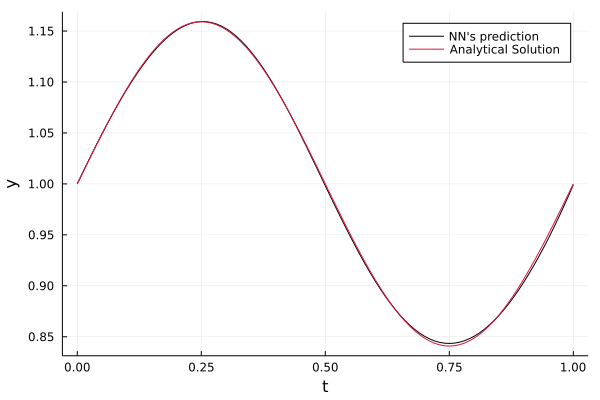

In [11]:
plot(T,Ψ1.(T),color = "black", label="NN's prediction")
plot!(T, F_target1.(T), color = "crimson", label = "Analytical Solution")
xlabel!("t")
ylabel!("y")

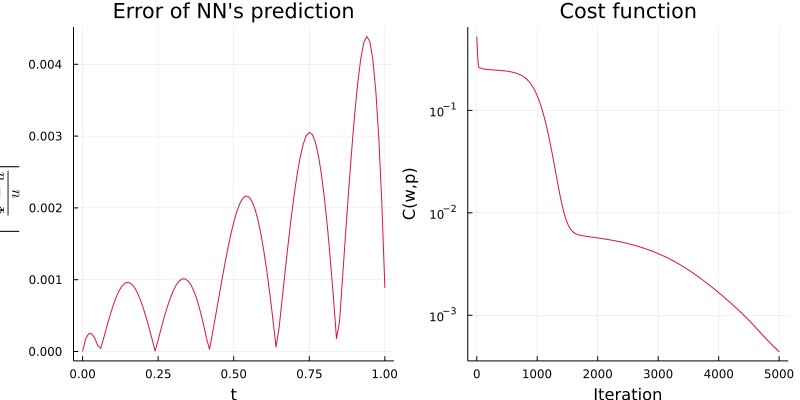

In [12]:
p1 = plot(T,abs.((Ψ1.(T) - F_target1.(T))./F_target1.(T)),color = "crimson", title="Error of NN's prediction",
        label=false, xlabel="t", ylabel=L"\left|\frac{\Psi - u}{u}\right|")
p2 = plot(1:it, history1, color="crimson", title="Cost function", label=false, 
        xlabel="Iteration", yaxis=:log, ylabel = "C(w,p)")
plot(p1, p2, layout = (1, 2), legend = false, size = (800, 400))

## Example 2

Let's consider an exponential decay of a physical quantity $u(t)$ represented by the next ODE:

<div id="solve_expdec"></div>
$$
\begin{equation} \label{solve_expdec} \tag{10}
  u'(t) = -\gamma u(t),
\end{equation}
$$

and the initial condition $u(0)=1$ and $t\in[0,1]$. In this example, we'll take $\gamma = 2$.

The analytical solution of the IVP in ([10](#solve_expdec)) is

<div id="AnSOl2"></div>
$$
\begin{equation}\label{AnSOL2} \tag{11}
  u(t) = u_0 \exp\left(-\gamma t\right).
\end{equation}
$$

In [13]:
NNODE2 = Chain(t -> [t], # Take in a scalar and transform it into an array
           Dense(1,32,tanh),
           Dense(32,1),first) # Take first value, i.e. return a scalar
NNODE2(1.0)

0.265688999120204

In [14]:
Ψ2(t) = Ψ(t; NN=NNODE2, u0 = 10)

Ψ2 (generic function with 1 method)

In [15]:
gamma = 2
loss2() = 0.5*mean(abs2(((Ψ2(t+ϵ)-Ψ2(t-ϵ))/(2*ϵ)) + gamma*Ψ2(t)) for t in T) # Loss function

loss2 (generic function with 1 method)

In [16]:
iter = 0
history2 = zeros(it)
cb2 = function () #callback function to observe training
    global iter += 1
    global history2
    history2[iter]= loss2()
    if iter % 500 == 0
        display(iter)
        display(history2[iter])
    end
end
display(loss2())

209.06884765625

In [17]:
Flux.train!(loss2, Flux.params(NNODE2), data, opt; cb = cb2)

500

28.962221145629883

1000

16.69107437133789

1500

3.585972785949707

2000

1.205271601676941

2500

0.854753851890564

3000

0.5808724164962769

3500

0.3347371220588684

4000

0.15886947512626648

4500

0.07021290063858032

5000

0.035567253828048706

In [18]:
F_target2(t) = 10*exp(-gamma*t) # Analytical solution

F_target2 (generic function with 1 method)

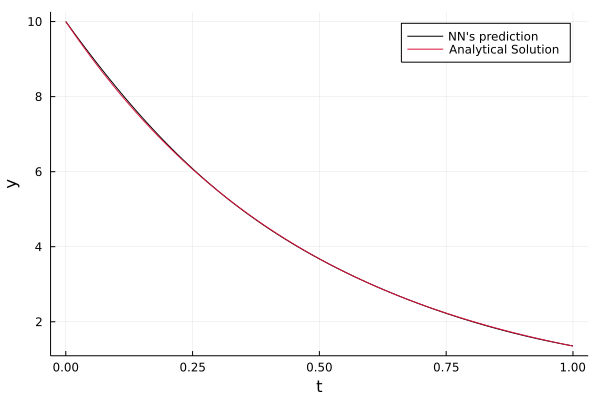

In [19]:
plot(T,Ψ2.(T),color = "black", label="NN's prediction")
plot!(T, F_target2.(T), color = "crimson", label = "Analytical Solution")
xlabel!("t")
ylabel!("y")

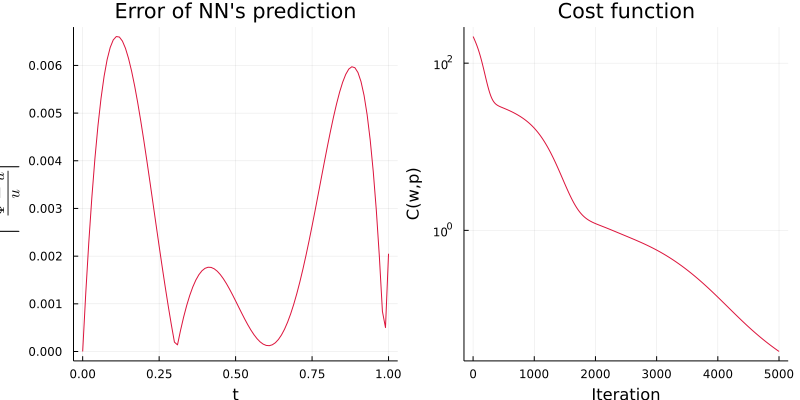

In [20]:
p1 = plot(T,abs.((Ψ2.(T) - F_target2.(T))./F_target2.(T)),color = "crimson", title="Error of NN's prediction",
        label=false, xlabel="t", ylabel=L"\left|\frac{\Psi - u}{u}\right|")
p2 = plot(1:it, history2, color="crimson", title="Cost function", label=false, 
        xlabel="Iteration", yaxis=:log, ylabel = "C(w,p)")
plot(p1, p2, layout = (1, 2), legend = false, size = (800, 400))

## Example 3

- ODE: 

<div id="ExamODE3"></div>
$$
\begin{equation} \label{ExamODE3} \tag{12}
  u'(t) + \left(t + \frac{1+3t^2}{1+t+t^3}\right)u= t^3+ 2t + t^2\left(\frac{1+3t^2}{1+t+t^3}\right),
\end{equation}
$$

with $u(0)=1$ and $t \in [0,1]$.

- Analytical solution:

<div id="AnSOL3"></div>
$$
\begin{equation} \label{ANSOL3} \tag{13}
  u(t) = \frac{1}{1+t+t^3}e^{-\frac{t^2}{2}} + t^2.
\end{equation}
$$

In [21]:
NNODE3 = Chain(t -> [t], # Take in a scalar and transform it into an array
           Dense(1,32,tanh),
           Dense(32,1),first) # Take first value, i.e. return a scalar
NNODE3(1.0)

0.09360452604390557

In [22]:
Ψ3(t) = Ψ(t; NN=NNODE3, u0 = 1)

Ψ3 (generic function with 1 method)

In [23]:
loss3() = 0.5*mean(abs2(((Ψ3(t+ϵ)-Ψ3(t-ϵ))/(2*ϵ)) + (t + (1+3*t^2)/(1+t+t^3))*Ψ3(t) - (t^3 + 2*t + t^2*((1+3*t^2)/(1+t+t^3)))) for t in T) # Loss function

loss3 (generic function with 1 method)

In [24]:
iter = 0
history3 = zeros(it)
cb3 = function () #callback function to observe training
    global iter += 1
    global history3
    history3[iter]= loss3()
    if iter % 500 == 0
        display(iter)
        display(history3[iter])
    end
end
display(loss3())

0.25683462619781494

In [25]:
Flux.train!(loss3, Flux.params(NNODE3), data, opt; cb = cb3)

500

0.001319091534242034

1000

0.001111167250201106

1500

0.0009033799287863076

2000

0.0006696264608763158

2500

0.0003877625858876854

3000

0.00016476523887831718

3500

0.00010721122816903517

4000

0.00010097330232383683

4500

9.682860400062054e-5

5000

9.225356188835576e-5

In [26]:
F_target3(t) = exp(-t^2 / 2)/(1+t+t^3)+t^2 # Analytical solution

F_target3 (generic function with 1 method)

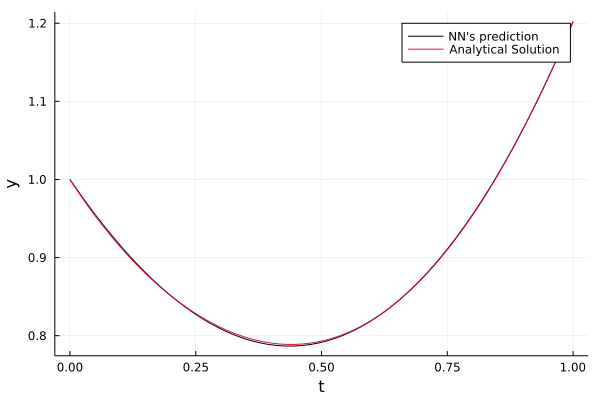

In [27]:
plot(T,Ψ3.(T),color = "black", label="NN's prediction")
plot!(T, F_target3.(T), color = "crimson", label = "Analytical Solution")
xlabel!("t")
ylabel!("y")

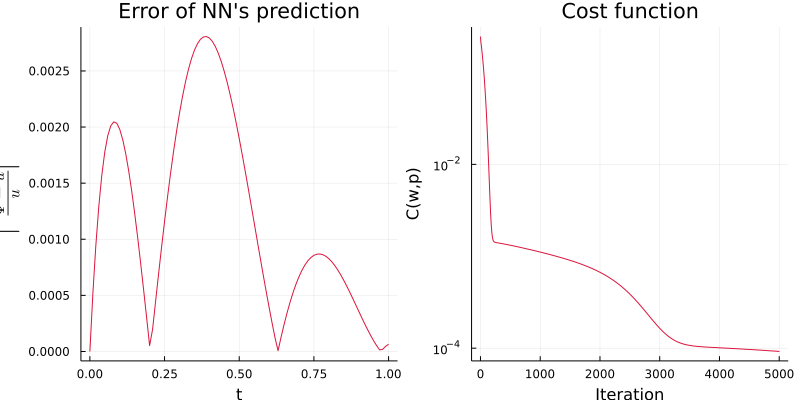

In [28]:
p1 = plot(T,abs.((Ψ3.(T) - F_target3.(T))./F_target3.(T)),color = "crimson", title="Error of NN's prediction",
        label=false, xlabel="t", ylabel=L"\left|\frac{\Psi - u}{u}\right|")
p2 = plot(1:it, history3, color="crimson", title="Cost function", label=false, 
        xlabel="Iteration", yaxis=:log, ylabel = "C(w,p)")
plot(p1, p2, layout = (1, 2), legend = false, size = (800, 400))

## Mixed boundary condition

## Example 1

- ODE: 

<div id="ExamODE4"></div>
$$
\begin{equation} \label{ExamODE4} \tag{14}
  \frac{d^2u(t)}{dt^2} + \frac{du}{dt}+u = -e^{-t}\cos{(t)},
\end{equation}
$$

with $u(0)=0$ and $u^\prime(0)=1$, for $t \in [0,2]$.

- Analytical solution:

<div id="AnSOL5"></div>
$$
\begin{equation} \label{ANSOL5} \tag{15}
  u(t) = e^{-t}\sin{(t)}.
\end{equation}
$$



- Trial Solution:

<div id="TriSOL5"></div>
$$
\begin{equation} \label{TriSOL5} \tag{16}
  u(t) = t + t^2 NN (t, w).
\end{equation}
$$


In [29]:
NNODE4 = Chain(t -> [t], # Take in a scalar and transform it into an array
           Dense(1,32,tanh),
           Dense(32,1),first) # Take first value, i.e. return a scalar
NNODE4(1.0)

-0.45025343709041005

In [30]:
Ψ4(t) = t + (t^2)*NNODE4(t) # Trial solution

Ψ4 (generic function with 1 method)

In [31]:
T2 = 0:1f-2:2f0 # Domain of solution V

0.0f0:0.01f0:2.0f0

In [32]:
loss4() = 0.5*mean(abs2(((Ψ4(t+ϵ)+Ψ4(t-ϵ)-2*Ψ4(t))/(ϵ^2)) + ((Ψ4(t+ϵ)-Ψ4(t-ϵ))/(2*ϵ)) + Ψ4(t) + exp(-t)*cos(t)) for t in T) # Loss function

loss4 (generic function with 1 method)

In [33]:
data = Iterators.repeated((), it) # Iterations
iter = 0
history4 = zeros(it)
cb4 = function () #callback function to observe training
    global iter += 1
    global history4
    history4[iter]= loss4()
    if iter % 500 == 0
        display(iter)
        display(history4[iter])
    end
end
display(loss4())

0.7895501852035522

In [34]:
Flux.train!(loss4, Flux.params(NNODE4), data, opt; cb = cb4)

500

0.0837230384349823

1000

0.11129137873649597

1500

0.09370879083871841

2000

0.10972870141267776

2500

0.12879678606987

3000

0.08978477120399475

3500

0.14724396169185638

4000

0.09354545921087265

4500

0.07376974076032639

5000

0.11470754444599152

In [35]:
F_target4(t) = exp(-t)*sin(t) # Analytical solution

F_target4 (generic function with 1 method)

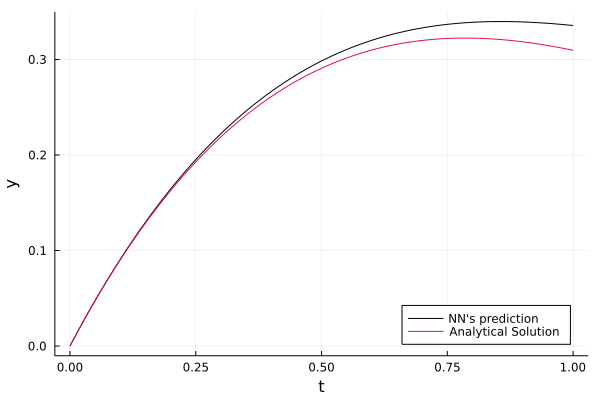

In [36]:
plot(T,Ψ4.(T),color = "black", label="NN's prediction", legend=:bottomright)
plot!(T, F_target4.(T), color = "crimson", label = "Analytical Solution")
xlabel!("t")
ylabel!("y")

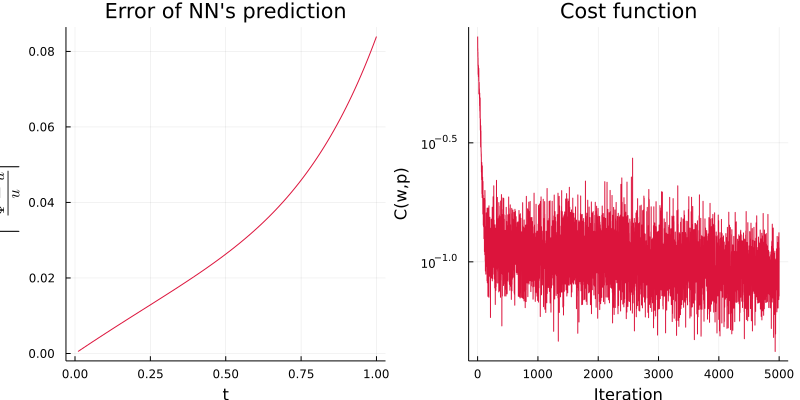

In [37]:
p1 = plot(T,abs.((Ψ4.(T) - F_target4.(T))./F_target4.(T)),color = "crimson", title="Error of NN's prediction",
        label=false, xlabel="t", ylabel=L"\left|\frac{\Psi - u}{u}\right|")
p2 = plot(1:it, history4, color="crimson", title="Cost function", label=false, 
        xlabel="Iteration", yaxis=:log, ylabel = "C(w,p)")
plot(p1, p2, layout = (1, 2), legend = false, size = (800, 400))

## References

1. `Lagaris, Isaac & Likas, Aristidis & Fotiadis, Dimitrios. (1998). Artificial neural networks for solving ordinary and partial differential equations. IEEE Transactions on Neural Networks. 9. 987-1000. 10.1109/72.712178.`

2. `Rackauckas, Chris. (2020). Introduction to Scientific Machine Learning through Physics-Informed Neural Networks.`https://book.sciml.ai/course/

3. `Larrañaga, Eduard. (2022). Notes of Physics Informed Neural Networks (PINNs).`